# 第8回演習：深層学習への発展

本演習では以下の内容を扱います:

1.  **モデルの層数と性能の関係**: モデルを深くすること（層を増やすこと）が性能にどのような影響を与えるかを確認します。
2.  **正則化手法の効果**: 過学習を抑制するための代表的な正則化手法であるL1正則化とL2正則化の効果を比較します。
3.  **時系列データを扱うモデル**: RNNの一種であるLSTMを用いて時系列データの予測を行い、古典的なモデルとの性能を比較します。

## 0. 準備：ライブラリのインポートと環境設定

In [1]:
import sys
import torch

date = "date"
print(f"実施日: {date}")

print(f"\n📌 Pythonバージョン: {sys.version.split()[0]}")
print(f"📌 PyTorchバージョン: {torch.__version__}")

# GPU利用可能か確認
if torch.cuda.is_available():
    print(f"✅ GPU利用可能: {torch.cuda.get_device_name(0)}")
    print(
        f"   GPUメモリ: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB"
    )
    device = "cuda"
else:
    print("⚠️  GPUが利用できません。CPUで実行します。")
    device = "cpu"

実施日: date

📌 Pythonバージョン: 3.12.11
📌 PyTorchバージョン: 2.8.0+cu126
✅ GPU利用可能: NVIDIA GeForce GTX 1080 Ti
   GPUメモリ: 10.90 GB


In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_covtype
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# 警告メッセージを非表示にする
warnings.filterwarnings("ignore")

# 日本語フォントの設定（環境に応じてフォント名を変更してください）
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS", "DejaVu Sans", "Hiragino Maru Gothic ProN"]

## 演習1: モデルの層数と性能の関係

この演習では、層数を変えた複数のモデルを学習させ、モデルの深さが訓練データとテストデータに対する精度にどのような影響を与えるかを実験的に確認します。

### 1.1 データセットの準備

scikit-learnの`Covertype Dataset`を使用します．
これは、米国コロラド州の4つの原生地域における森林の被覆タイプを予測する多クラス分類問題です．

**データセットの特徴**
データ数: 581,012件
特徴量数: 54次元
クラス数: 7種類の森林被覆タイプ

**特徴量**
連続値変数（10次元）
- 標高（Elevation）
- 方位（Aspect）: 0〜360度
- 傾斜（Slope）: 度数
- 最寄りの水域までの距離（Horizontal_Distance_To_Hydrology）
- 最寄りの道路までの距離（Horizontal_Distance_To_Roadways）
- 最寄りの山火事地点までの距離（Horizontal_Distance_To_Fire_Points）
- 午前9時の日射量（Hillshade_9am）
- 正午の日射量（Hillshade_Noon）
- 午後3時の日射量（Hillshade_3pm）
- 最寄りの水域までの垂直距離（Vertical_Distance_To_Hydrology）

カテゴリカル変数（エンコーディング済み）
- 原生地域タイプ（4次元）: 4つの原生地域を one-hot エンコーディング
- 土壌タイプ（40次元）: 40種類の土壌分類を one-hot エンコーディング

**クラス（目的変数）：7種類の樹種優占タイプ**
1. Spruce/Fir（トウヒ/モミ）
2. Lodgepole Pine（ロッジポールパイン）
3. Ponderosa Pine（ポンデローサマツ）
4. Cottonwood/Willow（ポプラ/ヤナギ）
5. Aspen（ヤマナラシ）
6. Douglas-fir（ベイマツ）
7. Krummholz（高山低木林）

今回は，計算時間を短縮するためデータの一部をランダムにサンプリングして使用します．

取得元
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html

In [ ]:
covtype = fetch_covtype(download_if_missing=True)
X = covtype.data
y = covtype.target - 1  # ラベルを1-7から0-6に変換

# 学習時間を抑えるためデータをダウンサンプリング
n_samples = 20000
indices = np.random.choice(len(X), n_samples, replace=False)
X = X[indices]
y = y[indices]

# 訓練データとテストデータに分割
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 特徴量の標準化（スケールを揃えることで学習を安定させる）
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)

# PyTorchで扱えるようにTensorに変換
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.long).to(device)
X_test = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test_np, dtype=torch.long).to(device)

# DataLoaderの作成（データをバッチ単位で効率的に供給するため）
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

n_features = X_train.shape[1]
n_classes = len(np.unique(y))

print(f"\n訓練データ: {X_train.shape}, テストデータ: {X_test.shape}")
print(f"特徴量数: {n_features}, クラス数: {n_classes}")


訓練データ: torch.Size([16000, 54]), テストデータ: torch.Size([4000, 54])
特徴量数: 54, クラス数: 7


### 1.2 モデルの定義と学習

指定された層数の全結合ネットワークを生成する関数を定義します．
次に層数を `[1, 3, 5, 7, 10]` と変えながら，それぞれのモデルを学習させて性能を記録します．

In [4]:
def create_model(n_layers, input_features, units_per_layer=64):
    """
    指定された層数のモデルを作成する関数 (PyTorch)
    活性化関数にはReLUを使用します。
    """
    layers = []
    # 入力層
    layers.append(nn.Linear(input_features, units_per_layer))
    layers.append(nn.ReLU())

    # 中間層
    for _ in range(n_layers - 1):
        layers.append(nn.Linear(units_per_layer, units_per_layer))
        layers.append(nn.ReLU())

    # 出力層
    layers.append(nn.Linear(units_per_layer, n_classes))

    return nn.Sequential(*layers)

# 異なる層数でモデルを学習
layer_configs = [1, 3, 5, 7, 10]
results = []

for n_layers in layer_configs:
    print(f"\n層数: {n_layers}")

    model = create_model(n_layers, n_features).to(device)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    n_epochs = 50

    history = {"accuracy": [], "val_accuracy": []}

    for epoch in tqdm(range(n_epochs), desc=f"Training {n_layers}-layer model"):
        model.train() # モデルを訓練モードに
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad() # 勾配をリセット
            outputs = model(batch_X) # 順伝播
            loss = criterion(outputs, batch_y) # 損失を計算
            loss.backward() # 逆伝播（勾配を計算）
            optimizer.step() # パラメータを更新

        # エポックごとに性能を評価
        model.eval() # モデルを評価モードに
        with torch.no_grad(): # 勾配計算を無効化
            # 訓練データに対する精度
            train_outputs = model(X_train)
            _, train_preds = torch.max(train_outputs, 1)
            train_acc = (train_preds == y_train).float().mean().item()
            history["accuracy"].append(train_acc)

            # テストデータに対する精度
            test_outputs = model(X_test)
            _, test_preds = torch.max(test_outputs, 1)
            val_acc = (test_preds == y_test).float().mean().item()
            history["val_accuracy"].append(val_acc)

    # 最終的な性能を記録
    results.append({
        "n_layers": n_layers,
        "train_acc": history["accuracy"][-1],
        "val_acc": history["val_accuracy"][-1],
        "history": history,
    })

    print(f"  最終訓練精度: {history['accuracy'][-1]:.4f}")
    print(f"  最終検証精度: {history['val_accuracy'][-1]:.4f}")


層数: 1


Training 1-layer model: 100%|██████████| 50/50 [00:06<00:00,  7.26it/s]


  最終訓練精度: 0.7852
  最終検証精度: 0.7723

層数: 3


Training 3-layer model: 100%|██████████| 50/50 [00:07<00:00,  6.51it/s]


  最終訓練精度: 0.8094
  最終検証精度: 0.7658

層数: 5


Training 5-layer model: 100%|██████████| 50/50 [00:08<00:00,  5.61it/s]


  最終訓練精度: 0.8398
  最終検証精度: 0.7970

層数: 7


Training 7-layer model: 100%|██████████| 50/50 [00:10<00:00,  5.00it/s]


  最終訓練精度: 0.8440
  最終検証精度: 0.7968

層数: 10


Training 10-layer model: 100%|██████████| 50/50 [00:11<00:00,  4.20it/s]

  最終訓練精度: 0.8559
  最終検証精度: 0.8015


### 1.3 結果の可視化と考察

学習結果をグラフで可視化し、モデルの層数と精度の関係を分析します。

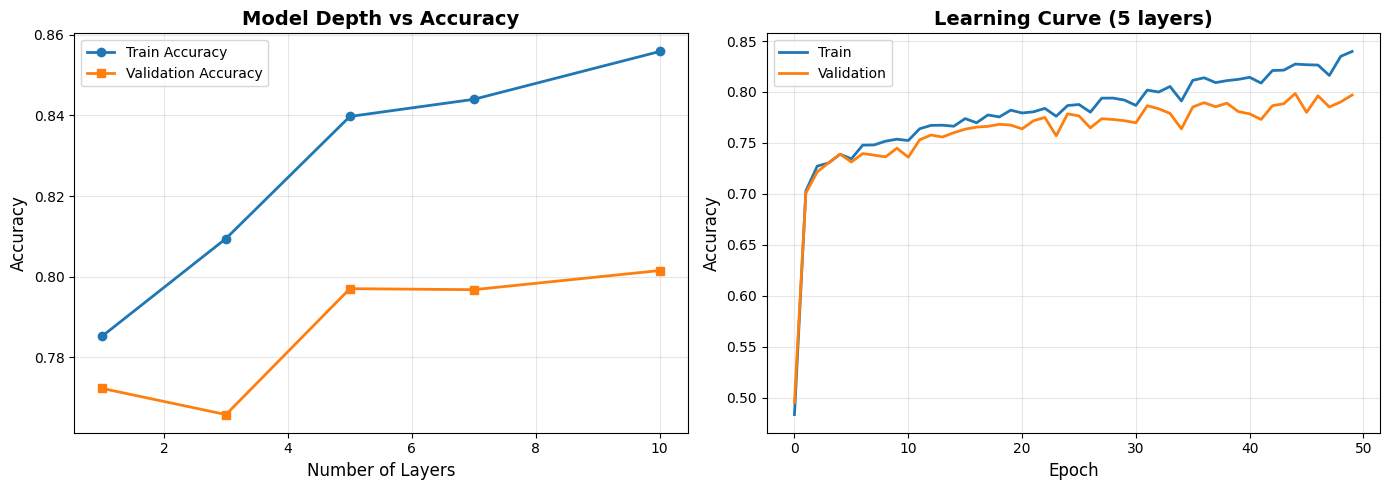

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# グラフ1: 層数と最終精度の関係
layer_nums = [r["n_layers"] for r in results]
train_accs = [r["train_acc"] for r in results]
val_accs = [r["val_acc"] for r in results]

ax1.plot(layer_nums, train_accs, "o-", label="Train Accuracy", linewidth=2)
ax1.plot(layer_nums, val_accs, "s-", label="Validation Accuracy", linewidth=2)
ax1.set_xlabel("Number of Layers", fontsize=12)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.set_title("Model Depth vs Accuracy", fontsize=14, fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)

# グラフ2: 5層モデルの学習曲線
try:
    history_5layer = [r for r in results if r["n_layers"] == 5][0]["history"]
    ax2.plot(history_5layer["accuracy"], label="Train", linewidth=2)
    ax2.plot(history_5layer["val_accuracy"], label="Validation", linewidth=2)
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Accuracy", fontsize=12)
    ax2.set_title("Learning Curve (5 layers)", fontsize=14, fontweight="bold")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
except IndexError:
    ax2.text(0.5, 0.5, '5-layer model data not found',
             horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.savefig("exercise1_depth_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

#### 考察
**訓練精度（Train Accuracy）**
- 層数が増えるにつれて，
- このことから，

**検証精度（Validation Accuracy）**
- 検証データに対する精度は，
- このことから

これらの結果から，モデルの性能を最大化するためには，単純に層を深くするだけでなく，過学習を抑制する工夫（次の演習で扱う正則化など）が必要であることがわかります．

## 演習2: 正則化手法の効果

この演習では，代表的な正則化手法である**L1正則化**と**L2正則化**の効果を比較します．

- **L1正則化 (Lasso)**: 損失関数に重みの絶対値の和（L1ノルム）を加えます．一部の重みを完全に0にする性質があり，**特徴量選択**の効果が期待できます．
- **L2正則化 (Ridge)**: 損失関数に重みの二乗和（L2ノルム）を加えます．重みの値を全体的に小さく抑える効果があります。`Adam`オプティマイザの`weight_decay`引数で簡単に実装できます．

In [8]:
class RegularizedModel(nn.Module):
    def __init__(self):
        super(RegularizedModel, self).__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, n_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

lambda_l1 = 0.0005
lambda_l2 = 0.001
regularization_configs = [
    ("No Regularization", None, 0),
    (f"L1 (lambda={lambda_l1})", "l1", lambda_l1),
    (f"L2 (lambda={lambda_l2})", "l2", lambda_l2),
]

reg_results = []
l1_feature_importance = None

print("\n各正則化手法でのモデル学習を開始...")

for name, reg_type, reg_lambda in regularization_configs:
    print(f"\n{name}")

    model = RegularizedModel().to(device)
    # L2正則化はoptimizerのweight_decayで設定
    l2_lambda = reg_lambda if reg_type == "l2" else 0
    optimizer = optim.Adam(model.parameters(), weight_decay=l2_lambda)
    criterion = nn.CrossEntropyLoss()
    n_epochs = 50

    history = {"accuracy": [], "val_accuracy": []}

    for epoch in tqdm(range(n_epochs), desc=f"Training {name}"):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # L1正則化項を損失に手動で追加
            if reg_type == "l1":
                l1_penalty = sum(p.abs().sum() for p in model.parameters())
                loss += reg_lambda * l1_penalty

            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train)
            _, train_preds = torch.max(train_outputs, 1)
            train_acc = (train_preds == y_train).float().mean().item()
            history["accuracy"].append(train_acc)

            test_outputs = model(X_test)
            _, test_preds = torch.max(test_outputs, 1)
            val_acc = (test_preds == y_test).float().mean().item()
            history["val_accuracy"].append(val_acc)

    reg_results.append({
        "name": name,
        "train_acc": history["accuracy"][-1],
        "val_acc": history["val_accuracy"][-1],
        "history": history,
    })

    print(f"  最終訓練精度: {history['accuracy'][-1]:.4f}")
    print(f"  最終検証精度: {history['val_accuracy'][-1]:.4f}")
    overfit_gap = history["accuracy"][-1] - history["val_accuracy"][-1]
    print(f"  過学習の度合い（訓練精度 - 検証精度）: {overfit_gap:.4f}")

    # L1正則化の場合、特徴量の重要度を保存
    if reg_type == "l1":
        weights = model.fc1.weight.detach().cpu().numpy()
        l1_feature_importance = np.abs(weights).sum(axis=0)


各正則化手法でのモデル学習を開始...

No Regularization


Training No Regularization: 100%|██████████| 50/50 [00:07<00:00,  6.33it/s]


  最終訓練精度: 0.8271
  最終検証精度: 0.7898
  過学習の度合い（訓練精度 - 検証精度）: 0.0374

L1 (lambda=0.0005)


Training L1 (lambda=0.0005): 100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


  最終訓練精度: 0.7738
  最終検証精度: 0.7645
  過学習の度合い（訓練精度 - 検証精度）: 0.0093

L2 (lambda=0.001)


Training L2 (lambda=0.001): 100%|██████████| 50/50 [00:07<00:00,  6.50it/s]

  最終訓練精度: 0.8073
  最終検証精度: 0.7793
  過学習の度合い（訓練精度 - 検証精度）: 0.0281


### 2.1 結果の可視化と考察

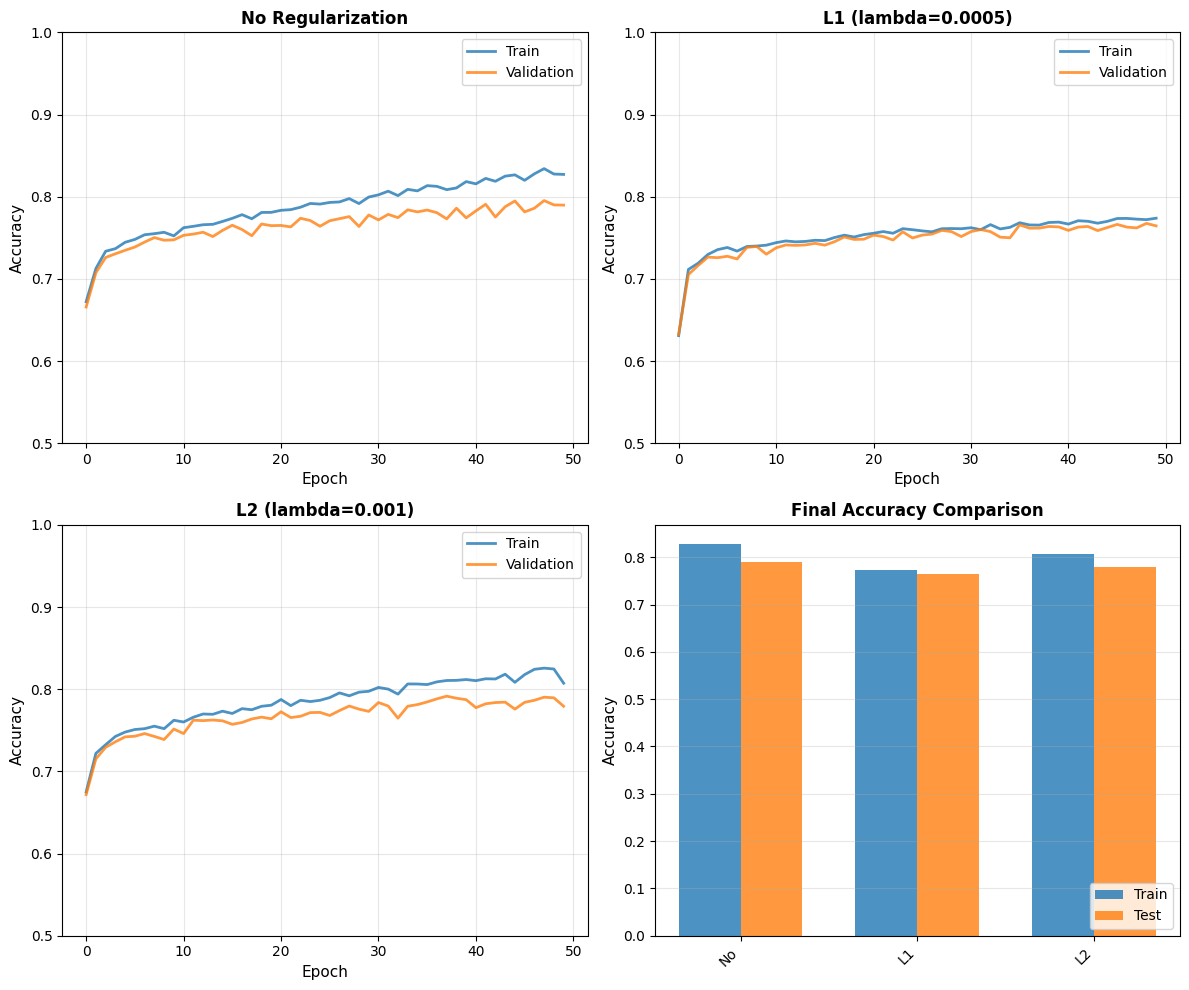

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# 各モデルの学習曲線
for idx, result in enumerate(reg_results):
    ax = axes[idx]
    history = result["history"]
    ax.plot(history["accuracy"], label="Train", linewidth=2, alpha=0.8)
    ax.plot(history["val_accuracy"], label="Validation", linewidth=2, alpha=0.8)
    ax.set_xlabel("Epoch", fontsize=11)
    ax.set_ylabel("Accuracy", fontsize=11)
    ax.set_title(result["name"], fontsize=12, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.5, 1.0])

# 最終精度の比較
ax = axes[3]
names = [r["name"] for r in reg_results]
train_accs = [r["train_acc"] for r in reg_results]
test_accs = [r["val_acc"] for r in reg_results]
x = np.arange(len(names))
width = 0.35
ax.bar(x - width / 2, train_accs, width, label="Train", alpha=0.8)
ax.bar(x + width / 2, test_accs, width, label="Test", alpha=0.8)
ax.set_ylabel("Accuracy", fontsize=11)
ax.set_title("Final Accuracy Comparison", fontsize=12, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels([name.split()[0] for name in names], rotation=45, ha="right")
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig("exercise2_regularization.png", dpi=150, bbox_inches="tight")
plt.show()

#### 考察

**学習曲線**
- 正則化を適用したモデル（L1, L2）は，適用しなかったモデルと比較して，

**最終精度**
- 今回の実験では，正則化を適用したモデルの訓練精度・検証精度は，適用しなかったモデルと比較して同等以下であった．ハイパーパラメータである正則化の係数の最適化や，より大規模で冗長な特徴量を含むデータセットの学習であれば，正則化が汎化性能向上に有効に作用すると考えられる．

### 2.2 L1正則化による特徴量重要度

L1正則化は不要な特徴量の重みを0に近づけるため，どの特徴量が予測に重要であったかを分析するのに役立ちます．
モデルの第1層の重みの絶対値の合計を計算し，特徴量の重要度として可視化します．

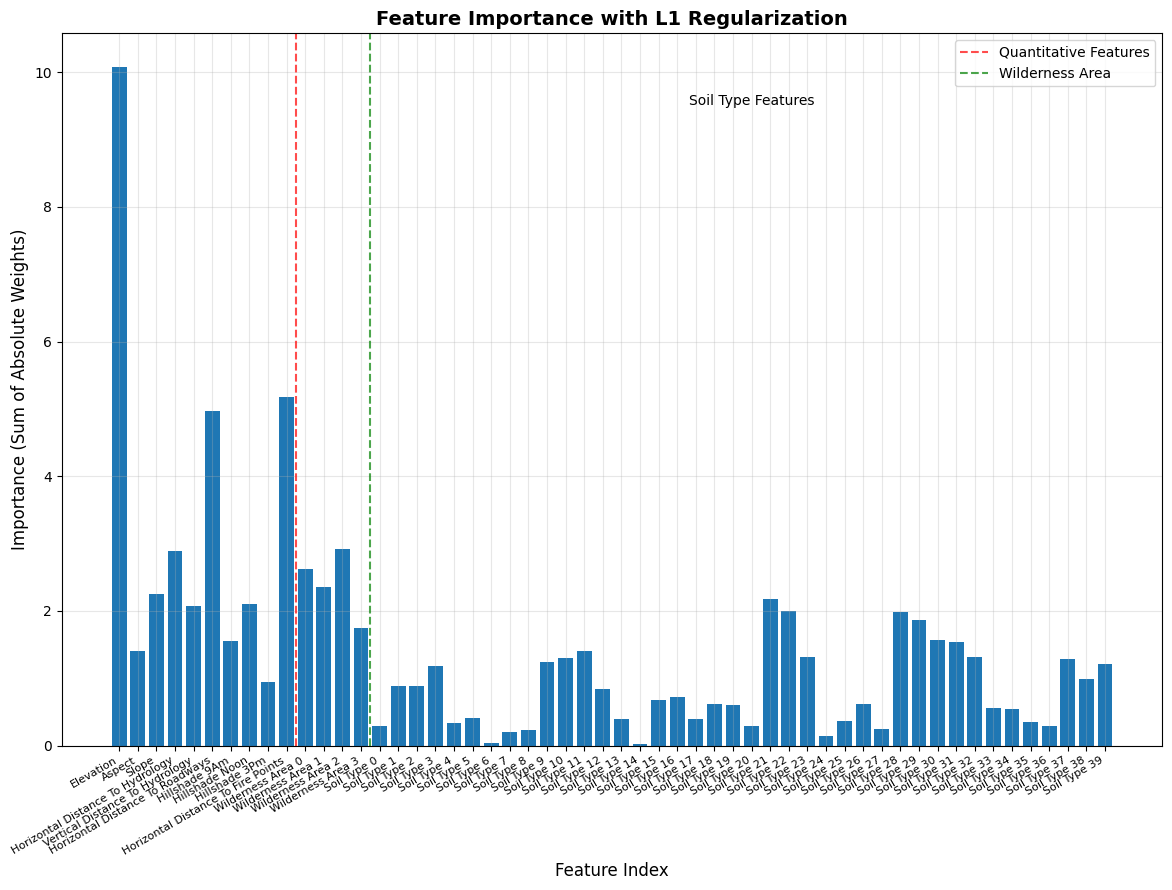

In [14]:
if l1_feature_importance is not None:
    plt.figure(figsize=(12, 9))
    # 特徴量名が長いので、一部を省略
    feature_names = [name.replace('_', ' ').title() for name in covtype.feature_names]

    plt.bar(range(len(l1_feature_importance)), l1_feature_importance)
    plt.xlabel("Feature Index", fontsize=12)
    plt.xticks(
        range(len(l1_feature_importance)),
        feature_names,
        rotation=30,
        ha="right",
        fontsize=8,
    )

    plt.ylabel("Importance (Sum of Absolute Weights)", fontsize=12)
    plt.title("Feature Importance with L1 Regularization", fontsize=14, fontweight="bold")

    # 特徴量の種類の境界線を表示（Covertypeデータセットの構造に基づく）
    # 0-9: 数値データ (10個)
    # 10-13: Wilderness Area (4個, One-hot)
    # 14-53: Soil Type (40個, One-hot)
    plt.axvline(x=9.5, color="r", linestyle="--", alpha=0.7, label="Quantitative Features")
    plt.axvline(x=13.5, color="g", linestyle="--", alpha=0.7, label="Wilderness Area")
    plt.text(34, plt.ylim()[1] * 0.9, "Soil Type Features", ha="center", color="black")
    plt.legend()

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("exercise2_l1_feature_importance.png", dpi=150, bbox_inches="tight")
    plt.show()

#### 考察

モデルがより重要な特徴量として，

## 演習3: 時系列データを扱うモデル（古典的モデル vs LSTM）

この演習では、航空会社の月間乗客数のデータセットを用いて、翌月の乗客数を予測するタスクに挑戦します。そして、古典的な統計モデルである**線形回帰**と**LSTM**の性能を比較します。

### 3.1 データセットの準備

Seabornライブラリに含まれる`flights`データセットを使用します．
これは，1949年から1960年までの月間航空機乗客数を記録した時系列データです．

**データセットの特徴**
- **データ数**: 144件（12年間 × 12ヶ月）
- **期間**: 1949年1月〜1960年12月
- **変数数**: 3次元
- **データタイプ**: 時系列データ（月次集計）

**特徴量**
- **year**: 年（1949〜1960）
- **month**: 月（Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec）
- **passengers**: 月間乗客数（単位：千人）

時系列予測では，「過去N個のデータを使って次の1個のデータを予測する」という形式のデータセットを作成する必要があります．
これを**シーケンスデータ**と呼びます．

**取得元**
- Seaborn: https://github.com/mwaskom/seaborn-data
- 原典: Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) *Time Series Analysis, Forecasting and Control.* Third Edition. Holden-Day.

In [3]:
flights = sns.load_dataset("flights")
data = flights["passengers"].values.astype(float)

# データの正規化（スケールを揃える）
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()

def create_sequences(data, seq_length):
    """過去のデータから未来のデータを予測するためのシーケンスデータを作成する関数"""
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i : i + seq_length] # 過去seq_length分のデータ
        y = data[i + seq_length]      # 翌月のデータ
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 過去12ヶ月（1年）のデータから翌月を予測する
SEQ_LENGTH = 12
X, y = create_sequences(data_normalized, SEQ_LENGTH)

# 訓練データとテストデータに分割 (時系列データなのでシャッフルしない)
train_size = int(len(X) * 0.8)
X_train_np, X_test_np = X[:train_size], X[train_size:]
y_train_np, y_test_np = y[:train_size], y[train_size:]

# PyTorchのTensorに変換 (LSTMの入力形式 [バッチサイズ, シーケンス長, 特徴量数] に合わせる)
X_train_ts = torch.tensor(X_train_np, dtype=torch.float32).unsqueeze(-1).to(device)
y_train_ts = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(-1).to(device)
X_test_ts = torch.tensor(X_test_np, dtype=torch.float32).unsqueeze(-1).to(device)
y_test_ts = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(-1).to(device)

print(f"全データ数: {len(data)}")
print(f"シーケンス生成後: {len(X)}")
print(f"訓練データ: {X_train_ts.shape}, テストデータ: {X_test_ts.shape}")

全データ数: 144
シーケンス生成後: 132
訓練データ: torch.Size([105, 12, 1]), テストデータ: torch.Size([27, 12, 1])


### 3.2 モデルの学習と比較

In [4]:
%pip install pmdarima

/home/KeiHiroshima/mda_2025/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

train_data_size = train_size + SEQ_LENGTH  # シーケンス作成で使用した分を考慮
train_data = data_normalized[:train_data_size]

print("\n古典的モデル（線形回帰）の学習...")
classical_model = ARIMA(y_train_np, order=(3,1,1))
classical_model_fitted = classical_model.fit()

y_pred_classical = classical_model_fitted.forecast(steps=len(y_test_np))
mae_classical = np.mean(np.abs(y_pred_classical - y_test_np))
print(f"古典的モデル - テストMAE: {mae_classical:.4f}")

auto_arima_model = auto_arima(
    train_data,
    seasonal=True,
    m=12,  # 季節周期
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True  # 探索過程を表示
)
y_pred_auto_arima = auto_arima_model.predict(n_periods=len(y_test_np))

# 評価
mae_auto_arima = np.mean(np.abs(y_pred_auto_arima - y_test_np))
print(f"Auto ARIMAモデル - テストMAE: {mae_auto_arima:.4f}")


ModuleNotFoundError: No module named 'pmdarima'

In [54]:
# --- LSTMモデルの定義 ---
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        # LSTM層: 隠れ状態の次元数を50に設定
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        # 全結合層: LSTMの最後のタイムステップの出力を受けて、1つの値を出力
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # xの形状: [バッチサイズ, シーケンス長, 1]
        out, _ = self.lstm(x)
        # 最後のタイムステップの出力のみを使用: out[:, -1, :]
        out = self.fc(out[:, -1, :])
        return out

# --- LSTMモデルの学習 ---
print("\nLSTMモデルの学習...")
lstm_model = LSTMModel().to(device)
criterion = nn.MSELoss() # 回帰タスクなので平均二乗誤差を使用
optimizer = optim.Adam(lstm_model.parameters(), lr=0.01)
n_epochs = 2000

for epoch in tqdm(range(n_epochs), desc="Training LSTM"):
    lstm_model.train()
    optimizer.zero_grad()
    outputs = lstm_model(X_train_ts)
    loss = criterion(outputs, y_train_ts)
    loss.backward()
    optimizer.step()

lstm_model.eval()
with torch.no_grad():
    y_pred_lstm_ts = lstm_model(X_test_ts)
    y_pred_lstm = y_pred_lstm_ts.cpu().numpy().flatten()
    mae_lstm = np.mean(np.abs(y_pred_lstm - y_test_np))
print(f"LSTMモデル - テストMAE: {mae_lstm:.4f}")


LSTMモデルの学習...


Training LSTM: 100%|██████████| 2000/2000 [00:03<00:00, 518.41it/s]

LSTMモデル - テストMAE: 0.4155


### 3.3 結果の可視化と考察

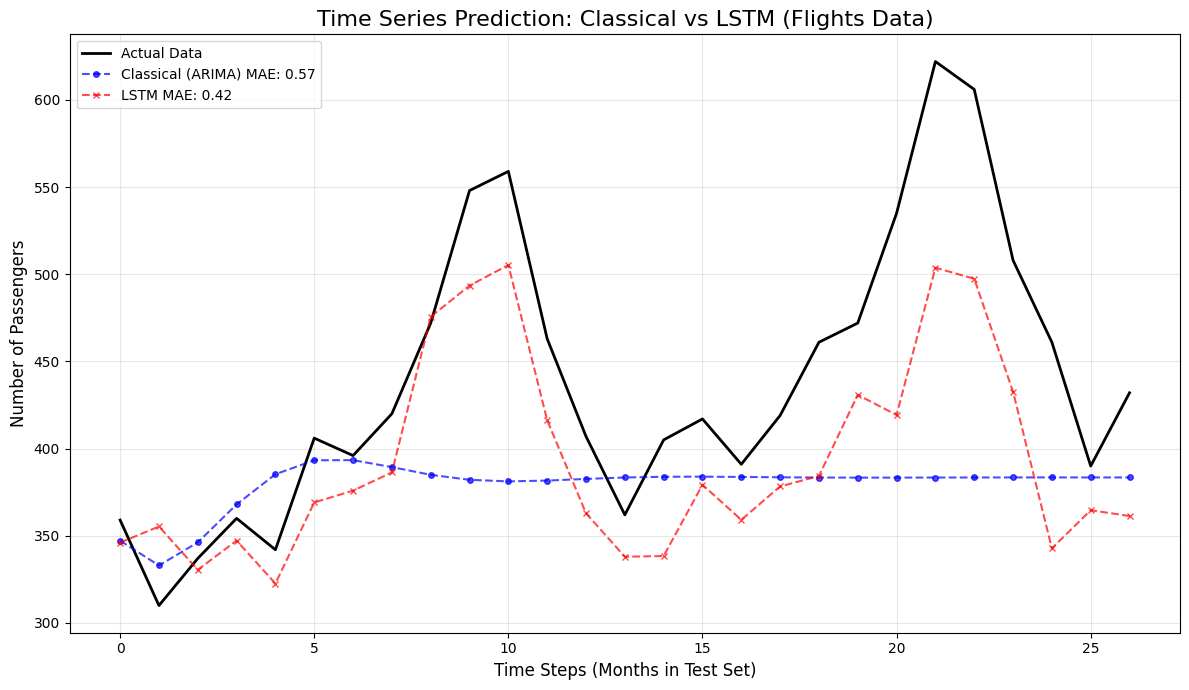

In [55]:
fig, ax = plt.subplots(figsize=(12, 7))

# 予測結果を元のスケールに戻す
y_test_inv = scaler.inverse_transform(y_test_np.reshape(-1, 1)).flatten()
y_pred_classical_inv = scaler.inverse_transform(y_pred_classical.reshape(-1, 1)).flatten()
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()

time_steps = np.arange(len(y_test_inv))

# 正解データのプロット
ax.plot(time_steps, y_test_inv, label="Actual Data", color="black", linewidth=2)

# 古典的モデルの予測
ax.plot(time_steps, y_pred_classical_inv,
        label=f"Classical (ARIMA) MAE: {mae_classical:.2f}",
        color="blue", linestyle="--", marker="o", markersize=4, alpha=0.7)

# LSTMモデルの予測
ax.plot(time_steps, y_pred_lstm_inv,
        label=f"LSTM MAE: {mae_lstm:.2f}",
        color="red", linestyle="--", marker="x", markersize=4, alpha=0.7)

ax.set_title("Time Series Prediction: Classical vs LSTM (Flights Data)", fontsize=16)
ax.set_xlabel("Time Steps (Months in Test Set)", fontsize=12)
ax.set_ylabel("Number of Passengers", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("exercise3_timeseries_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

#### 考察

グラフとMAE（平均絶対誤差、小さいほど良い）を比較すると、このデータセットではLSTMが線形回帰モデルよりも良い予測精度を達成していることがわかります。線形回帰モデルは全体的な傾向は捉えていますが、季節性のような周期的な変動をうまくモデル化できていません。一方、LSTMはより柔軟にデータのパターンを学習し、実際の値に近い予測ができています。

## 演習のまとめ

本演習で学んだこと:

1.  **モデルの深層化**
    -   層数を増やすことで表現力は向上するが、深すぎると過学習のリスクが高まる。
    -   適切な層数の選択が重要。

2.  **正則化手法（L1/L2ノルム）**
    -   過学習を防ぐための重要な技術。
    -   L1は不要な特徴量を削減し、L2は重みを全体的に小さく抑える。

3.  **時系列データとLSTM**
    -   LSTMは時系列データが持つ時間的な依存関係を捉えるのに有効。
    -   特に、複雑な非線形パターンを持つデータで、古典的なモデルを大きく上回る性能を発揮する。

これらの技術を理解し、適切に組み合わせることで、より高性能で安定した深層学習モデルを構築することができます。